Реализация PINN на pytorch взята отсюда: https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb

#Уравнение второго порядка:

коэффициенты

In [25]:
import math
n=1
a=1.
alpha=1.
beta=1.
k=1.
z0=-55.
th0=0.
w=9/8
l = (4. * alpha * n ** 2) / (a + n * a)
nu = (4. * beta * n ** 2) / (a + 2. * n * a)
mu = (4. * n ** 2 * (w - a * k ** 2)) / a

решение

In [26]:
def q(x,t):
  const = math.exp((x-2*a*k*t-z0)*math.sqrt(mu))
  return [math.pow(((4*mu) / ((1/const)+2*l+(l**2-4*mu*nu)*const)), 1/(2*n)) * math.cos(k*x-w*t+th0),
  math.pow(((4*mu) / ((1/const)+2*l+(l**2-4*mu*nu)*const)), 1/(2*n)) * math.sin(k*x-w*t+th0)]

In [27]:
!pip install pyDOE

In [28]:
import torch
from collections import OrderedDict #упорядоченный словарь
from pyDOE import lhs #функция, выбирающая значения для обучения на них нейросети
import numpy as np
import time
np.random.seed(1234)

In [29]:
#можно сменить среду выполнения на gpu и обучение будет происходить быстрее
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [30]:
def q_tensor(x,t): #тензорная функция q, принимающая на вход тензоры из координат x и t и возвращающая тензоры из u и v
  const = torch.exp((x-2*a*k*t-z0)*math.sqrt(mu))
  return [torch.pow(((4*mu*const) / (1+2*l*const+(l**2-4*mu*nu)*const**2)), 1/(2*n)) * torch.cos(k*x-w*t+th0),
                             torch.pow(((4*mu*const) / (1+2*l*const+(l**2-4*mu*nu)*const**2)), 1/(2*n))*torch.sin(k*x-w*t+th0)]

In [31]:
class SinActivation(torch.nn.Module): #кастомная функция активации - sin
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

нейросеть, в виде которой будет находиться решение

In [32]:
class DNN(torch.nn.Module):
    def __init__(self, layers): #принимает на вход массив целых чисел
        super(DNN, self).__init__() #вызывает метод init(почему нельзя сделать это без super?)

        self.depth = len(layers) - 1
        self.activation = SinActivation #в качестве функции активации используется tanh

        layer_list = list() #список с весами и функциями активации для каждого слоя
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])) #каждые два слоя образуют двудольный граф
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])) #нельзя сделать в цикле, потому что нет функции активации
        )

        layerDict = OrderedDict(layer_list) #сделали упорядоченный словарь, чтобы при использовании элементы выдавались в том порядке, в котором были добавлены

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) #собственно, задали архитектуру нейросети

    def forward(self, x):
        out = self.layers(x)
        return out

наконец, PINN

In [33]:
class PhysicsInformedNN():
    def __init__(self, X_uv, u, v, X_f, layers, lb, ub, a, alpha, beta):

        # граничные условия
        self.lb = torch.tensor(lb).float().to(device) #левое
        self.ub = torch.tensor(ub).float().to(device) #правое

        # данные для обучения
        #self.x_uv = torch.tensor(X_uv[:, 0:1], requires_grad=True).float().to(device) #для граничных условий: (x_uv, t_uv, u, v) (без разделения точек на граничные и начальные условия)
        #self.t_uv = torch.tensor(X_uv[:, 1:2], requires_grad=True).float().to(device)
        #self.u = torch.tensor(u).float().to(device)
        #self.v = torch.tensor(v).float().to(device)
        self.x_in = torch.tensor(X_uv_train[(X_uv_train[:,1]==t_0)][:, 0:1], requires_grad=True).float().to(device) #для граничных условий, причём отдельно начальные(initial) условия и отдельно граничные(boundary)
        self.t_in = torch.tensor(X_uv_train[(X_uv_train[:,1]==t_0)][:, 1:2], requires_grad=True).float().to(device)
        self.u_in = torch.tensor(u_train[(X_uv_train[:,1]==t_0)]).float().to(device)
        self.v_in = torch.tensor(v_train[(X_uv_train[:,1]==t_0)]).float().to(device)
        self.x_b = torch.tensor(X_uv_train[(X_uv_train[:,0]==x_0) | (X_uv_train[:,0]==x_1)][:, 0:1], requires_grad=True).float().to(device)
        self.t_b = torch.tensor(X_uv_train[(X_uv_train[:,0]==x_0) | (X_uv_train[:,0]==x_1)][:, 1:2], requires_grad=True).float().to(device)
        self.u_b = torch.tensor(u_train[(X_uv_train[:,0]==x_0) | (X_uv_train[:,0]==x_1)]).float().to(device)
        self.v_b = torch.tensor(v_train[(X_uv_train[:,0]==x_0) | (X_uv_train[:,0]==x_1)]).float().to(device)

        #self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device) #для уравнения: (x_f, t_f, f=0) (используются переданные сети точки)
        #self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 0:1], requires_grad=True).float().to(device) #создаём N_f точек для обучения соответствия уравнению. те, что переданы, не используем
        self.t_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 1:2], requires_grad=True).float().to(device)

        #данные для законов сохранения
        self.x_fragments = 100 #разбиение при интегрировании по x при фиксированном t
        self.t_amount = 10 #в скольких точках t считается интеграл
        x_l = np.linspace(x_0, x_1, self.x_fragments).reshape(self.x_fragments,1)
        t_l = np.linspace(t_0, t_1, self.t_amount).reshape(self.t_amount,1)
        self.x_l = torch.tensor(x_l, requires_grad=True).float().to(device)
        self.t_l = torch.tensor(t_l, requires_grad=True).float().to(device)

        # числовые коэффициенты в уравнении
        self.a = a
        self.alpha = alpha
        self.beta = beta

        # модель
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # loss, которые нужны для коэффициентов в балансировке весов
        u_pred_in, v_pred_in = self.net_uv(self.x_in, self.t_in)
        u_pred_b, v_pred_b = self.net_uv(self.x_b, self.t_b)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
        self.L_u_in = torch.mean(((self.u_in - u_pred_in) ** 2)/2)
        self.L_v_in = torch.mean(((self.v_in - v_pred_in) ** 2)/2)
        self.L_u_b = torch.mean(((self.u_b - u_pred_b) ** 2)/2)
        self.L_v_b = torch.mean(((self.v_b - v_pred_b) ** 2)/2)
        self.L_u_f = torch.mean((f_u_pred ** 2)/2)
        self.L_v_f = torch.mean((f_v_pred ** 2)/2)

        # оптимизатор - LBFGS, обучает с точностью до 1e-5 или пока разница в точности уменьшается больше, чем точность float(?)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.0001,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"
        )

        self.adam = torch.optim.Adam(
          self.dnn.parameters(),
          lr=0.005,
          betas=(0.9, 0.999),
          eps=1e-08,
          weight_decay=0,
          amsgrad=False,
          foreach=None,
          maximize=False,
          capturable=False,
          differentiable=False,
          fused=None)

        self.iter = 0

    def net_uv(self, x, t): # вывод модели
        u = self.dnn(torch.cat([x, t], dim=1))[:,0:1]
        v = self.dnn(torch.cat([x, t], dim=1))[:,1:2]
        return u, v

    def net_f(self, x, t): #вывод  функции
        """ The pytorch autograd version of calculating residual """
        u, v = self.net_uv(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        v_t = torch.autograd.grad(
            v, t,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производая по t
        v_x = torch.autograd.grad(
            v, x,
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0] #производная по x
        v_xx = torch.autograd.grad(
            v_x, x,
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0] #вторая призводная по x

        f_u = -v_t + (self.a*u_xx + self.alpha*u*(u**2+v**2) - self.beta*u*(u**2+v**2)**2) #это и есть действительная и коплексная части исходного уравнения
        f_v = u_t + (self.a*v_xx + self.alpha*v*(u**2+v**2) - self.beta*v*(u**2+v**2)**2) #они получены путём подстановки q=u+i*v в него
        return f_u, f_v

    def first_law(self): #реализация первого закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в точке t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t), ведь она по сути дана в t_0
          initial_integral += (u**2 + v**2) * x_step

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            integral += (u**2 + v**2) * x_step
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #возвращаем средний квадрат отклонения

    def second_law(self): #реализация второго закона сохранения
        x_step=(self.x_l[1]-self.x_l[0]).item()
        initial_integral=0
        for j in range(0,self.x_fragments): #считаем интеграл по x в t_0
          u, v = self.net_uv(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от вывода нейросети
          #u, v = q_tensor(self.x_l[j:j+1], self.t_l[0:1]) #интеграл считается от q(x,t)
          u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
          v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
          initial_integral += ((v_x[j] * u - u_x[j] * v) * x_step)

        variation=np.zeros(self.t_amount)
        for i in range(1,self.t_amount): #сравниваем с интегралом по x в других точках
          integral=0
          for j in range(0,self.x_fragments):
            u, v = self.net_uv(self.x_l[j:j+1], self.t_l[i:i+1])
            u_x = torch.autograd.grad(u, self.x_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #почему-то градиент по self.x_l[j:j+1] посчитать не получается
            v_x = torch.autograd.grad(v, self.x_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0] #поэтому вычисляется градиент по self.x_l и берётся j элемент
            integral += ((v_x[j] * u - u_x[j] * v) * x_step)
          variation[i]=(initial_integral-integral)**2

        return variation.mean(axis=0) #опять возвращаем средний квадрат отклонения

    def loss_func(self): #функция потерь
        self.optimizer.zero_grad() #обнуляет градиенты

        u_pred_in, v_pred_in = self.net_uv(self.x_in, self.t_in)#реализация метода балансировки коэффициентов Soft Adapt
        u_pred_b, v_pred_b = self.net_uv(self.x_b, self.t_b)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)

        loss_u_in = torch.mean(((self.u_in - u_pred_in) ** 2)/2) #средний квадрат всех отклонений по u от начальных условий(/2 решил оставить чтобы не было двукратного увеличения loss относительно других экспериментов)
        loss_v_in = torch.mean(((self.v_in - v_pred_in) ** 2)/2) #средний квадрат всех отклонений по v от начальных условий
        loss_u_b = torch.mean(((self.u_b - u_pred_b) ** 2)/2) #средний квадрат всех отклонений по u от граничных условий
        loss_v_b = torch.mean(((self.v_b - v_pred_b) ** 2)/2) #средний квадрат всех отклонений по v от граничных условий
        loss_u_f = torch.mean((f_u_pred ** 2)/2) #средний квадрат всех отклонений по u от уравнения
        loss_v_f = torch.mean((f_v_pred ** 2)/2) #средний квадрат всех отклонений по v от уравнения

        L_u_in_prev = self.L_u_in
        L_v_in_prev = self.L_v_in
        L_u_b_prev = self.L_u_b
        L_v_b_prev = self.L_v_b
        L_u_f_prev = self.L_u_f
        L_v_f_prev = self.L_v_f
        self.L_u_in = loss_u_in
        self.L_v_in = loss_v_in
        self.L_u_b = loss_u_b
        self.L_v_b = loss_v_b
        self.L_u_f = loss_u_f
        self.L_v_f = loss_v_f
        denominator = math.exp(self.L_u_in/L_u_in_prev) + math.exp(self.L_v_in/L_v_in_prev) + math.exp(self.L_u_b/L_u_b_prev) + math.exp(self.L_v_b/L_v_b_prev) + math.exp(self.L_u_f/L_u_f_prev) + math.exp(self.L_v_f/L_v_f_prev)
        lambda_u_in=math.exp(self.L_u_in/L_u_in_prev)/denominator
        lambda_v_in=math.exp(self.L_v_in/L_v_in_prev)/denominator
        lambda_u_b=math.exp(self.L_u_b/L_u_b_prev)/denominator
        lambda_v_b=math.exp(self.L_v_b/L_v_b_prev)/denominator
        lambda_u_f=math.exp(self.L_u_f/L_u_f_prev)/denominator
        lambda_v_f=math.exp(self.L_v_f/L_v_f_prev)/denominator

        lambda_u_in_array.append(lambda_u_in) #записываем коэффициенты, чтобы потом построить графики
        lambda_v_in_array.append(lambda_v_in)
        lambda_u_b_array.append(lambda_u_b)
        lambda_v_b_array.append(lambda_v_b)
        lambda_u_f_array.append(lambda_u_f)
        lambda_v_f_array.append(lambda_v_f)
        iter_s_array.append(self.iter)

        #loss_fl = self.first_law()
        #loss_sl = self.second_law()

        #loss = loss_uv + loss_f + loss_fl + loss_sl
        loss = lambda_u_in*loss_u_in + lambda_v_in*loss_v_in + lambda_u_b*loss_u_b + lambda_v_b*loss_v_b + lambda_u_f*loss_u_f + lambda_v_f*loss_v_f

        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u_in: %.5e, Loss_v_in: %.5e, Loss_u_b: %.5e, Loss_v_b: %.5e, Loss_u_f: %.5e, Loss_v_f: %.5e'
                 %(self.iter, loss.item(), loss_u_in.item(), loss_v_in.item(), loss_u_b.item(), loss_v_b.item(), loss_u_f.item(), loss_v_f.item())
            )
            #print('loss_fl: %.5e' %loss_fl.item())
            #print('loss_sl: %.5e' %loss_sl.item())
            u_pred_current, v_pred_current, f_u_pred_current, f_v_pred_current = self.predict(X_star)
            mse_q_current = (((u_star**2+v_star**2)**0.5 - (u_pred_current**2+v_pred_current**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
            mse_q_array.append(mse_q_current) #запоминаем mse_q в текущей стадии обучения чтобы потом построить график
            loss_array.append(loss.item()) #loss тоже запоминаем для графика
            iter_array.append(self.iter)

        if self.iter % 10 == 0: #каждые 10 итераций генерируем новые точки для обучения
          random_points = lb + (ub-lb)*lhs(2, N_f)
          self.x_f = torch.tensor(random_points[:, 0:1], requires_grad=True).float().to(device)
          self.t_f = torch.tensor(random_points[:, 1:2], requires_grad=True).float().to(device)

        return loss

    def train(self): #обучение
        print('training started')
        print('100000 iterations of ADAM:')
        self.dnn.train()
        for i in range(100000): #во время тренировки производится 100000 шагов adam, а дальше запускается lbfgs
            if i % 100 == 0: self.adam.param_groups[0]['lr'] = 0.997*self.adam.param_groups[0]['lr'] #экспоненциальное уменьшение шага каждые 100 шагов
            self.adam.step(self.loss_func)
        print('LBFGS:')
        self.optimizer.step(self.loss_func)


    def predict(self, X): #вывод нейросети и функции на входных данных
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u, v = self.net_uv(x, t)
        f_u, f_v = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v

данные для обучения

In [34]:
N_u = 200 # число точек, обучающих принимать граничные значения
N_f = 30000 # число точек, обучающих удовлетворять уравнению
x_parts = 1000 #число частей, на которые разбивается отрезок x
t_parts = 100 #число частей, на которые разбивается отрезок t
layers = [2, 100, 100, 100, 100, 2] #2 входа, 2 выхода и 4 слоя по 100 нейронов

x_0=-85
x_1=85
t_0=0
t_1=50
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)
Exact_u=np.zeros((t_parts,x_parts))
Exact_v=np.zeros((t_parts,x_parts))
for i in range(0,t_parts):
  for j in range(0,x_parts):
    Exact_u[i][j]=q(X[i][j],T[i][j])[0]
    Exact_v[i][j]=q(X[i][j],T[i][j])[1]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения берём только данные на границах области(граничные условия по сути)
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
uu2 = np.zeros((t_parts,1)) #граничные условия поставил 0 в соответствии с требованиями
vv2 = np.zeros((t_parts,1))
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
uu3 = np.zeros((t_parts,1)) #тут тоже
vv3 = np.zeros((t_parts,1))

X_uv_train = np.vstack([xx1, xx2, xx3]) #данные для тренировки в точках на границе
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])
X_f_train = lb + (ub-lb)*lhs(2, N_f) #данные для тренировки в случайных точкам из области
X_f_train = np.vstack((X_f_train, X_uv_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False) #выберем из точек на границе только N_u
X_uv_train = X_uv_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

mse_q_array = [] #массив с mse_q для каждой сотой итерации обучения
loss_array = [] #аналогичный массив с loss
iter_array = [] #итерации с шагом 100
lambda_u_in_array = [] #массивы с коэффициентами на каждой итерации обучения
lambda_v_in_array = []
lambda_u_b_array = []
lambda_v_b_array = []
lambda_u_f_array = []
lambda_v_f_array = []
iter_s_array = [] #итерации с шагом 1

Обучение

In [35]:
model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_f_train, layers, lb, ub, a, alpha, beta)

In [36]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
100000 iterations of ADAM:
Iter 100, Loss: 2.13055e-04, Loss_u_in: 4.90001e-04, Loss_v_in: 5.67459e-04, Loss_u_b: 2.83658e-06, Loss_v_b: 2.63484e-06, Loss_u_f: 1.29950e-04, Loss_v_f: 1.14636e-04
Iter 200, Loss: 3.69217e-05, Loss_u_in: 2.55657e-05, Loss_v_in: 1.80182e-05, Loss_u_b: 8.93049e-07, Loss_v_b: 7.34153e-07, Loss_u_f: 7.09036e-05, Loss_v_f: 1.05186e-04
Iter 300, Loss: 2.02151e-05, Loss_u_in: 1.11137e-05, Loss_v_in: 5.49514e-06, Loss_u_b: 1.62297e-07, Loss_v_b: 1.34986e-07, Loss_u_f: 4.21760e-05, Loss_v_f: 6.20076e-05
Iter 400, Loss: 1.55463e-05, Loss_u_in: 6.18361e-06, Loss_v_in: 3.77404e-06, Loss_u_b: 6.31423e-08, Loss_v_b: 4.70090e-08, Loss_u_f: 3.31713e-05, Loss_v_f: 5.03187e-05
Iter 500, Loss: 1.21263e-05, Loss_u_in: 4.66404e-06, Loss_v_in: 2.39859e-06, Loss_u_b: 5.67792e-08, Loss_v_b: 5.63712e-08, Loss_u_f: 2.77456e-05, Loss_v_f: 3.90900e-05
Iter 600, Loss: 5.28817e-04, Loss_u_in: 8.75774e-04, Loss_v_in: 2.04913e-03, Loss_u_b: 2.49403e-05, Loss_v_b: 5.4296

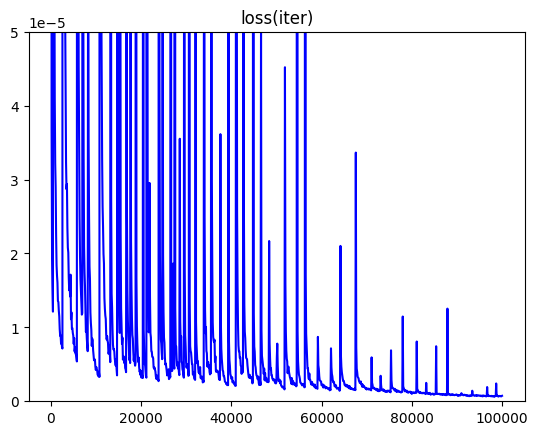

In [49]:
import matplotlib.pyplot as plt
plt.plot(np.array(iter_array), np.array(loss_array), color = "blue")
plt.ylim(0,5e-5)
plt.title('loss(iter)')
plt.show()

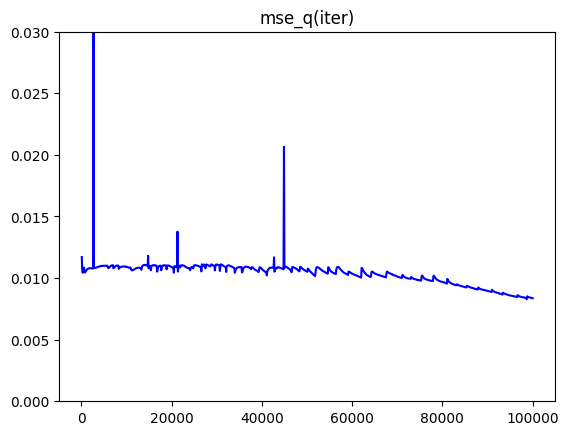

In [50]:
plt.plot(np.array(iter_array), np.array(mse_q_array), color = "blue")
plt.ylim(0,0.03)
plt.title('mse_q(iter)')
plt.show()

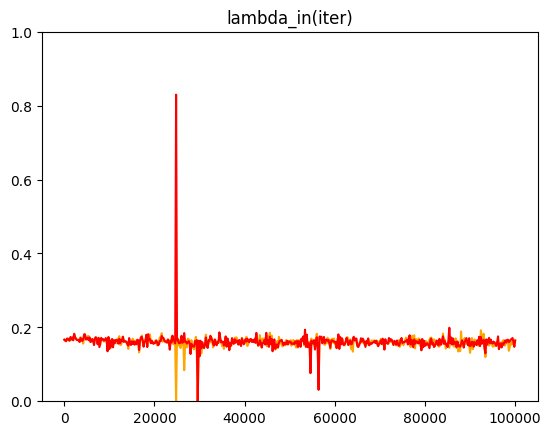

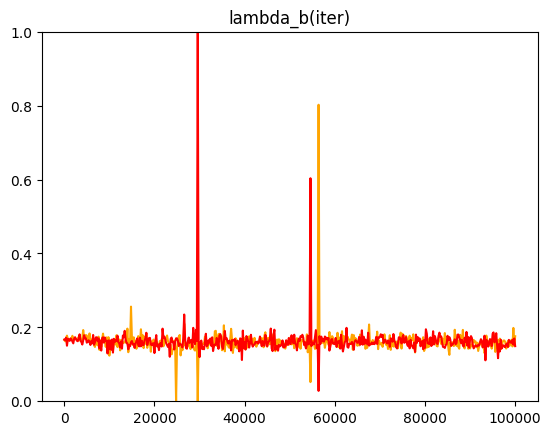

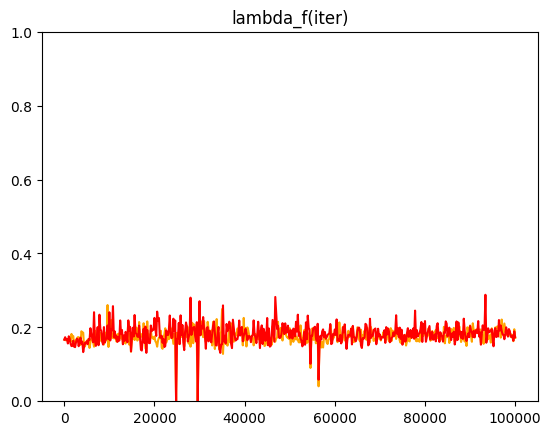

In [57]:
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_u_in_array)[::200], color = "orange") #графики коэффициентов при loss
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_v_in_array)[::200], color = "red")
plt.ylim(0,1)
plt.title('lambda_in(iter)')
plt.show()
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_u_b_array)[::200], color = "orange")
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_v_b_array)[::200], color = "red")
plt.ylim(0,1)
plt.title('lambda_b(iter)')
plt.show()
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_u_f_array)[::200], color = "orange")
plt.plot(np.array(iter_s_array)[::200], np.array(lambda_v_f_array)[::200], color = "red")
plt.ylim(0,1)
plt.title('lambda_f(iter)')
plt.show()

In [40]:
import pandas as pd #сохраняем в таблицу статистику обучения
df = pd.DataFrame([np.array(mse_q_array), np.array(loss_array), np.array(iter_array)], index=['mse_q', 'loss', 'iter'])
df.to_excel("stats.xlsx")

In [41]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) #предсказания модели в точках, в которых известно численное решение

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2) #относительная точность найденной функции u
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2) # и то же самое для v
error_f = np.linalg.norm(f_u_pred+f_v_pred,2) #абсолютная точность выполнения условий уравнения f=0
print('Rel error u: %e, Rel error v: %e, Abs error f: %e' % (error_u, error_v, error_f)) #довольно неплохие результаты, учитывая, что вектор f_pred имеет длину x_parts*t_parts=100000

mse_u = ((u_star-u_pred)**2).mean(axis=0).item()
mse_v = ((v_star-v_pred)**2).mean(axis=0).item()
mse_q = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2).mean(axis=0).item() #средний квадрат разности модулей
mse_f_u = ((f_u_pred)**2).mean(axis=0).item()
mse_f_v = ((f_v_pred)**2).mean(axis=0).item()
print('MSE_u: %e, MSE_v: %e, MSE_q: %e, MSE_f_u: %e, MSE_f_v: %e' %(mse_u, mse_v, mse_q, mse_f_u, mse_f_v)) #среднеквадратичное отклонение от известного решения во всех точках сетки

Rel error u: 1.020485e+00, Rel error v: 1.018486e+00, Abs error f: 9.601955e-01
MSE_u: 6.074734e-03, MSE_v: 6.050951e-03, MSE_q: 8.363874e-03, MSE_f_u: 4.822121e-06, MSE_f_v: 4.984156e-06


Визуализация

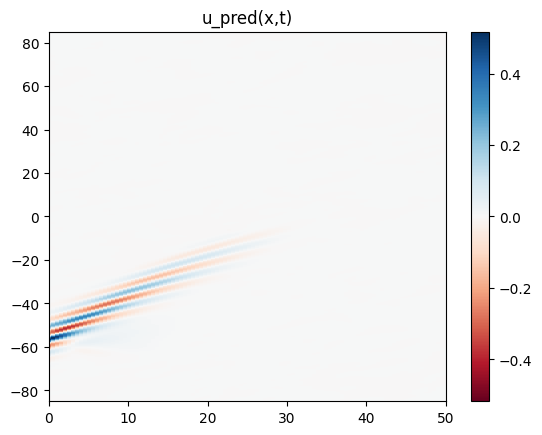

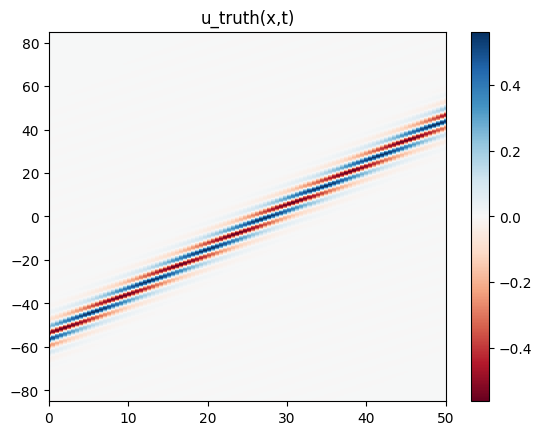

In [42]:
fig, ax = plt.subplots()
u_min, u_max = -np.abs(u_pred).max(), np.abs(u_pred).max()
c = ax.pcolormesh(T, X, u_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
#plt.scatter(X_uv_train[:,1], X_uv_train[:,0], s=7, color='black')
#plt.scatter(X_f_train[:,1], X_f_train[:,0], s=3, color='black', alpha=0.3)
plt.show()

fig, ax = plt.subplots()
u_min, u_max = -np.abs(Exact_u).max(), np.abs(Exact_u).max()
c = ax.pcolormesh(T, X, Exact_u, cmap='RdBu', vmin=u_min, vmax=u_max)
ax.set_title('u_truth(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

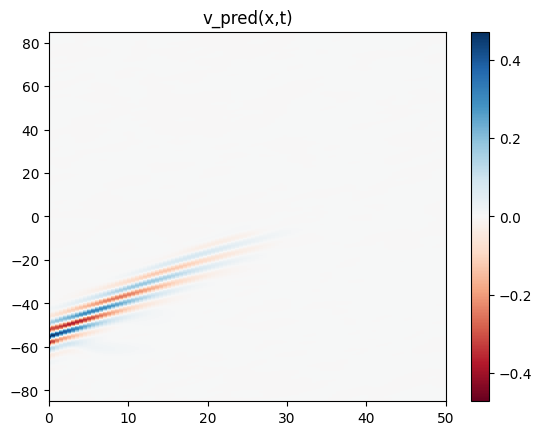

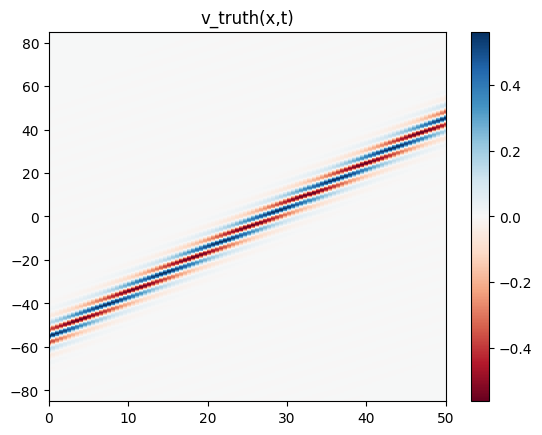

In [43]:
fig, ax = plt.subplots()
v_min, v_max = -np.abs(v_pred).max(), np.abs(v_pred).max()
c = ax.pcolormesh(T, X, v_pred.reshape((t_parts, x_parts)), cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_pred(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

fig, ax = plt.subplots()
v_min, v_max = -np.abs(Exact_v).max(), np.abs(Exact_v).max()
c = ax.pcolormesh(T, X, Exact_v, cmap='RdBu', vmin=v_min, vmax=v_max)
ax.set_title('v_truth(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

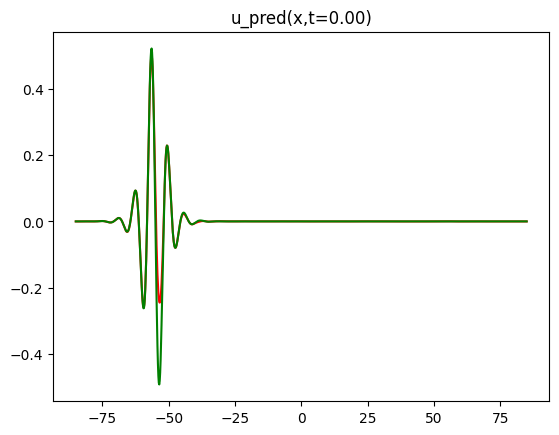

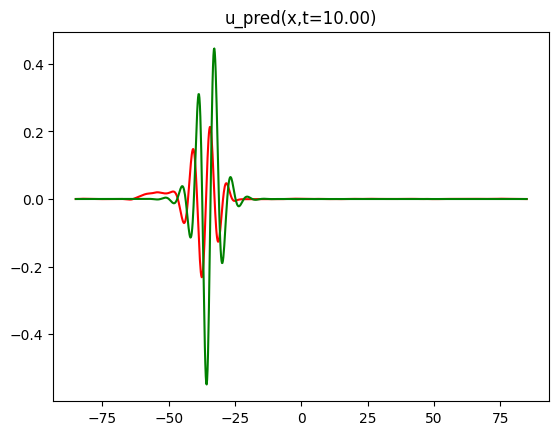

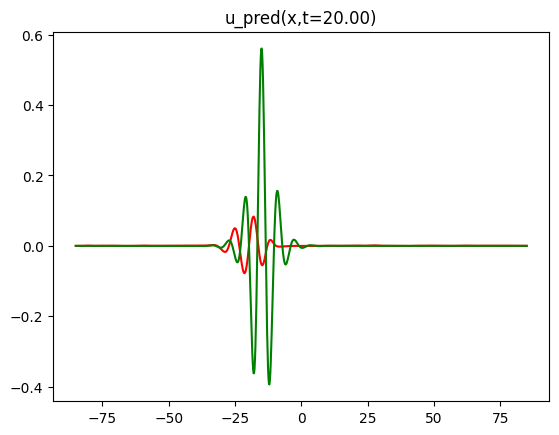

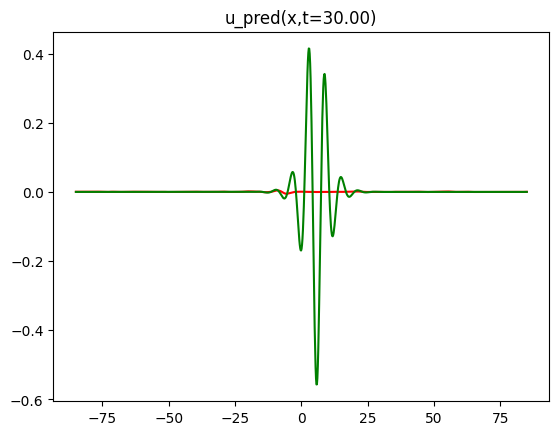

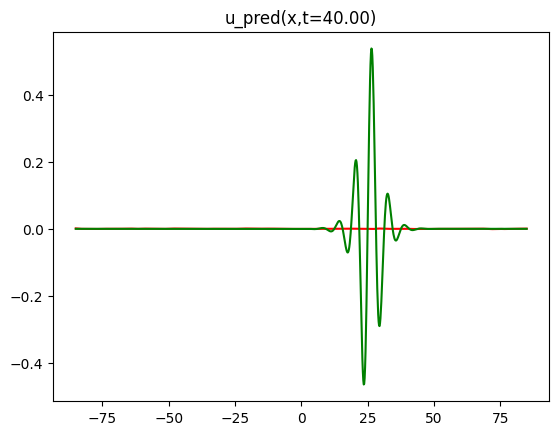

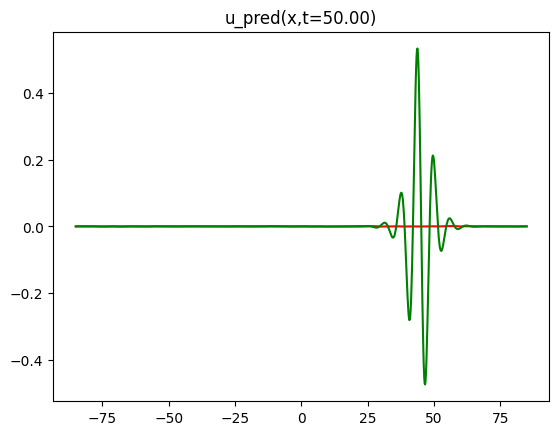

In [44]:
for t in range(t_0,t_1+1, 10):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], u_pred.reshape((t_parts, x_parts))[current_row,:], color = "red") #предсказанное решение
  plt.plot(X[current_row, :], Exact_u[current_row,:], color = "green") #аналитическое решение
  plt.title('u_pred(x,t=%.2f)'%t)
  plt.show()

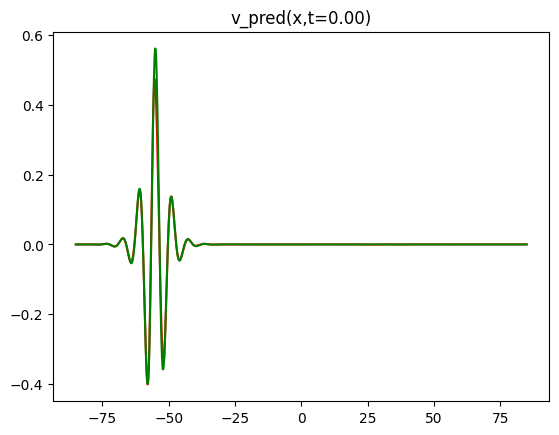

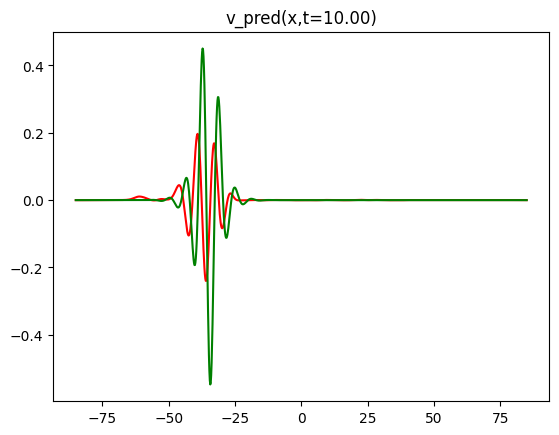

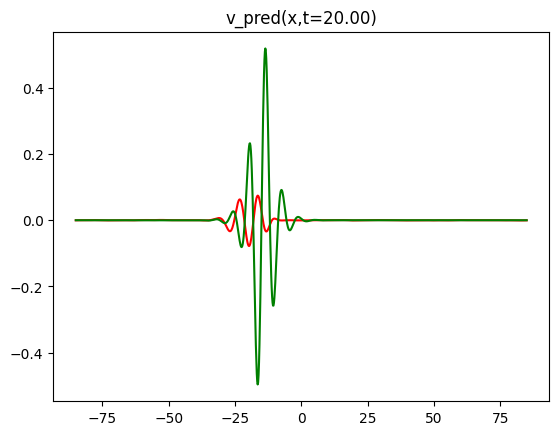

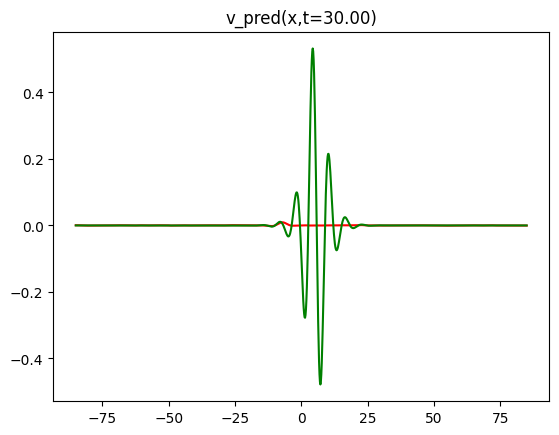

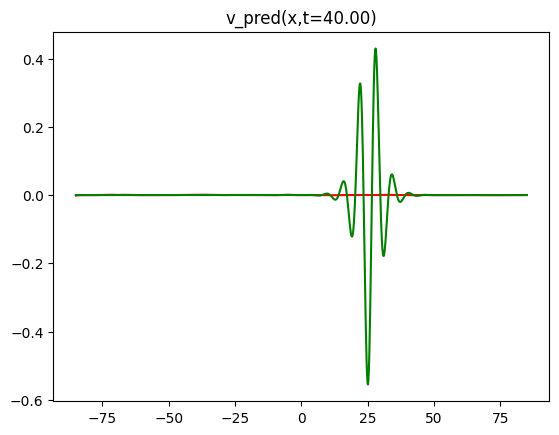

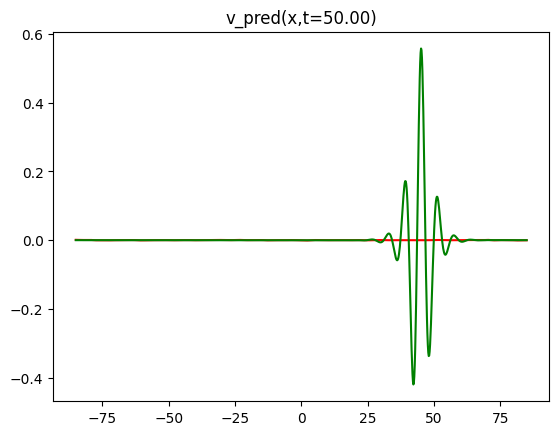

In [45]:
for t in range(t_0,t_1+1, 10):
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(X[current_row, :], v_pred.reshape((t_parts, x_parts))[current_row,:], color = "red")
  plt.plot(X[current_row, :], Exact_v[current_row,:], color = "green")
  plt.title('v_pred(x,t=%.2f)'%t)
  plt.show()

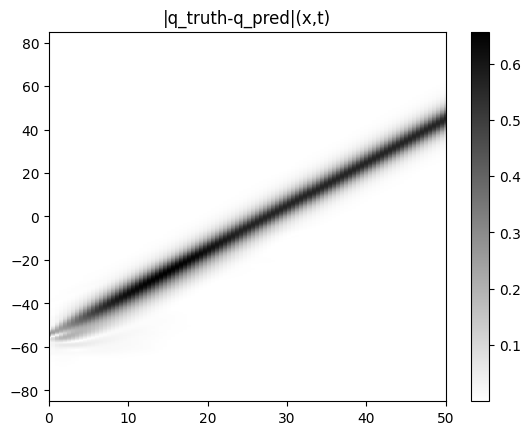

In [46]:
err = ((u_star-u_pred)**2 + (v_star-v_pred)**2)**0.5 #модуль разности q_truth и q_pred
fig, ax = plt.subplots()
e_min, e_max = err.min(), err.max()
c = ax.pcolormesh(T, X, err.reshape((t_parts, x_parts)), cmap='binary', vmin=e_min, vmax=e_max)
ax.set_title('|q_truth-q_pred|(x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

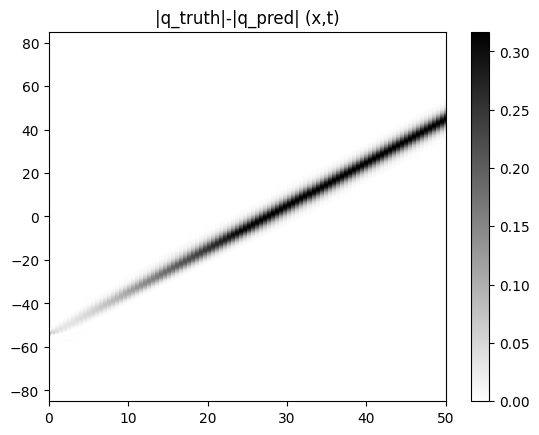

In [47]:
err = (((u_star**2+v_star**2)**0.5 - (u_pred**2+v_pred**2)**0.5)**2)
fig, ax = plt.subplots()
e_min, e_max = err.min(), err.max()
c = ax.pcolormesh(T, X, err.reshape((t_parts, x_parts)), cmap='binary', vmin=e_min, vmax=e_max)
ax.set_title('|q_truth|-|q_pred| (x,t)')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)
plt.show()

Проверка законов сохранения

In [48]:
x_fragments = 100 #разбиение при интегрировании по x при фиксированном t
t_amount = 10 #в скольких точках t считается интеграл
x_l = np.linspace(x_0, x_1, x_fragments).reshape(x_fragments,1)
t_l = np.linspace(t_0, t_1, t_amount).reshape(t_amount,1)
X_l = torch.tensor(x_l, requires_grad=True).float().to(device)
T_l = torch.tensor(t_l, requires_grad=True).float().to(device)

#реализация первого закона сохранения
x_step=(X_l[1]-X_l[0]).item()
initial_integral=0
for j in range(0,x_fragments): #считаем интеграл по x в точке t_0
  u, v = model.net_uv(X_l[j:j+1], T_l[0:1])
  initial_integral += (u**2 + v**2) * x_step

first_variation=np.zeros(t_amount)
for i in range(1,t_amount): #сравниваем с интегралом по x в других точках
  integral=0
  for j in range(0,x_fragments):
    u, v =model.net_uv(X_l[j:j+1], T_l[i:i+1])
    integral += (u**2 + v**2) * x_step
  first_variation[i]=(initial_integral-integral)**2
MSE_fl = first_variation.mean(axis=0).item() #возвращаем средний квадрат отклонения


initial_integral=0
for j in range(0,x_fragments): #считаем интеграл по x в t_0
  u, v = model.net_uv(X_l[j:j+1], T_l[0:1])
  u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
  v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
  initial_integral += ((v_x[j] * u - u_x[j] * v) * x_step)

second_variation=np.zeros(t_amount)
for i in range(1,t_amount): #сравниваем с интегралом по x в других точках
  integral=0
  for j in range(0,x_fragments):
    u, v = model.net_uv(X_l[j:j+1], T_l[i:i+1])
    u_x = torch.autograd.grad(u, X_l, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #почему-то градиент по self.x_l[j:j+1] посчитать не получается
    v_x = torch.autograd.grad(v, X_l, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0] #поэтому вычисляется градиент по self.x_l и берётся j элемент
    integral += ((v_x[j] * u - u_x[j] * v) * x_step)
  second_variation[i]=(initial_integral-integral)**2
MSE_sl = second_variation.mean(axis=0).item() #опять возвращаем средний квадрат отклонения


print('First law MSE: %e, Second law MSE: %e' %(MSE_fl, MSE_sl))

First law MSE: 1.790576e+00, Second law MSE: 1.586387e+00
